# User Segmentation & Value Analysis (RFM Model)
Objectives:
- Segment e-commerce users based on RFM metrics
- Analyze value, satisfaction, and latency characteristics across different user segments
- Provide characteristics and business basis for subsequent churn prediction/precision marketing

## 1. Data Loading & Initial Exploration

In [72]:
# read data from sql:view_user_behavior
import pandas as pd
from src.utils.db import get_engine

# build connection with database
engine = get_engine()

# from view_user_behavior read "Aggregated behavioral data by user"
sql = "SELECT * FROM view_user_behavior"
df = pd.read_sql(sql, engine)

# close connection
engine.dispose()

# check head 5 row
df.head()

,unique_user_id,city,state,order_count,total_spent,avg_order_value,last_purchase_date,days_since_last_purchase,first_purchase_date,customer_lifetime_days
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar,SP,1,141.90,141.90,2018-05-10 10:56:27,2852,2018-05-10 10:56:27,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,SP,1,27.19,27.19,2018-05-07 11:11:27,2855,2018-05-07 11:11:27,0
2,0000f46a3911fa3c0805444483337064,sao jose,SC,1,86.22,86.22,2017-03-10 21:05:03,3278,2017-03-10 21:05:03,0
3,0000f6ccb0745a6a4b88665a16c9f078,belem,PA,1,43.62,43.62,2017-10-12 20:29:41,3062,2017-10-12 20:29:41,0
4,0004aac84e0df4da2b147fca70cf8255,sorocaba,SP,1,196.89,196.89,2017-11-14 19:45:42,3029,2017-11-14 19:45:42,0


In [73]:
# check the data
print("Shape", df.shape)    # how much row\columns
print("\nInfo:", df.info()) # type of every column\if have null value

print("\nDescribe (Columns related to RFM):")
print(df[['order_count', 'total_spent', 'days_since_last_purchase']].describe())

print("\nMissing values:", df.isnull().sum())

Shape (96219, 10)
<class 'pandas.DataFrame'>
RangeIndex: 96219 entries, 0 to 96218
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   unique_user_id            96219 non-null  str           
 1   city                      96219 non-null  str           
 2   state                     96219 non-null  str           
 3   order_count               96219 non-null  int64         
 4   total_spent               95539 non-null  float64       
 5   avg_order_value           95539 non-null  float64       
 6   last_purchase_date        96219 non-null  datetime64[us]
 7   days_since_last_purchase  96219 non-null  int64         
 8   first_purchase_date       96219 non-null  datetime64[us]
 9   customer_lifetime_days    96219 non-null  int64         
dtypes: datetime64[us](2), float64(2), int64(3), str(3)
memory usage: 7.3 MB

Info: None

Describe (Columns related to RFM):
        order_c

## 2. Exploratory Data Analysis (EDA)

In [74]:
# Clean up R/F/M fields(recency\frequency\monetary)
df_rfm = df.copy()

# Retain only: Users who have purchased at least once
df_rfm = df_rfm[df_rfm['order_count'] > 0].copy()

print("After filtering users with order_count > 0:")
print(df_rfm[['order_count', 'total_spent', 'days_since_last_purchase']].describe())

After filtering users with order_count > 0:
        order_count   total_spent  days_since_last_purchase
count  96219.000000  95539.000000              96219.000000
mean       1.033486    165.833359               2980.230173
std        0.210763    228.095176                153.439029
min        1.000000      9.590000               2692.000000
25%        1.000000     63.100000               2856.000000
50%        1.000000    107.850000               2961.000000
75%        1.000000    182.910000               3090.000000
max       17.000000  13664.080000               3465.000000


In [75]:
# Unified naming convention
df_rfm.rename(columns = {
    'days_since_last_purchase': 'recency',
    'order_count': 'frequency',
    'total_spent' : 'monetary'
}, inplace=True)

df_rfm[['unique_user_id', 'recency', 'frequency', 'monetary']].head()

,unique_user_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2852,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2855,1,27.19
2,0000f46a3911fa3c0805444483337064,3278,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,3062,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,3029,1,196.89


In [76]:
df_rfm[['recency', 'frequency', 'monetary']].isna().sum()

recency        0
frequency      0
monetary     680
dtype: int64

### 2.1 Missing Value Analysis & Handling

We identified missing values in the `monetary` field. Before proceeding with RFM analysis, we need to understand the nature and impact of these missing values.

In [79]:
# Missing Value Analysis
print("=" * 60)
print("Missing Value Analysis")
print("=" * 60)

total_records = len(df_rfm)
missing_monetary = df_rfm['monetary'].isna().sum()
missing_rate = missing_monetary / total_records * 100

print(f"\nTotal records: {total_records:,}")
print(f"Missing monetary values: {missing_monetary} ({missing_rate:.2f}%)")

# Examine characteristics of records with missing monetary
missing_df = df_rfm[df_rfm['monetary'].isna()]

if len(missing_df) > 0:
    print("\nCharacteristics of records with missing monetary:")
    print(missing_df[['recency', 'frequency']].describe())

    # Check if there's a pattern
    print("\nRecency distribution of missing records:")
    print(f"  Mean: {missing_df['recency'].mean():.2f}")
    print(f"  Median: {missing_df['recency'].median():.2f}")
else:
    print("\nNo missing values found.")
print("\n" + "=" * 60)
print("Decision: Dropping Missing Monetary Values")
print("=" * 60)
print("\nReasons:")
print("1. Missing rate is very low (<1%), minimal impact on analysis")
print("2. Monetary is a core RFM metric; imputation would introduce bias")
print("3. These likely represent cancelled orders or data quality issues")
print("4. Removing them ensures data integrity for value-based segmentation")

Missing Value Analysis

Total records: 96,219
Missing monetary values: 680 (0.71%)

Characteristics of records with missing monetary:
           recency   frequency
count   680.000000  680.000000
mean   3069.908824    1.013235
std     162.346964    0.126589
min    2692.000000    1.000000
25%    2974.750000    1.000000
50%    3056.000000    1.000000
75%    3184.250000    1.000000
max    3456.000000    3.000000

Recency distribution of missing records:
  Mean: 3069.91
  Median: 3056.00

Decision: Dropping Missing Monetary Values

Reasons:
1. Missing rate is very low (<1%), minimal impact on analysis
2. Monetary is a core RFM metric; imputation would introduce bias
3. These likely represent cancelled orders or data quality issues
4. Removing them ensures data integrity for value-based segmentation


### 2.2 Outlier Detection & Analysis

Using the IQR (Interquartile Range) method, we identify potential outliers in RFM metrics. This helps us understand extreme values and decide whether to retain or remove them.

In [80]:
# Outlier Detection using IQR Method
def detect_outliers_iqr(df, col):
    """
    Detect outliers using IQR method
    Returns: outliers DataFrame, lower_bound, upper_bound
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Before dropping missing values, check on the full dataset
df_rfm_check = df_rfm.dropna(subset=['monetary']).copy()

print("=" * 60)
print("Outlier Detection Results")
print("=" * 60)
outlier_summary = []
for col in ['recency', 'frequency', 'monetary']:
    outliers, lower, upper = detect_outliers_iqr(df_rfm_check, col)
    outlier_count = len(outliers)
    outlier_pct = outlier_count / len(df_rfm_check) * 100

    print(f"\n{col.upper()}:")
    print(f"  IQR bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  Outlier count: {outlier_count:,} ({outlier_pct:.2f}%)")
    print(f"  Min value: {df_rfm_check[col].min():.2f}")
    print(f"  Max value: {df_rfm_check[col].max():.2f}")

    if outlier_count > 0:
        print(f"  Outlier range: {outliers[col].min():.2f} to {outliers[col].max():.2f}")

    outlier_summary.append({
        'metric': col,
        'outliers': outlier_count,
        'percentage': outlier_pct
    })

print("\n" + "=" * 60)
print("Decision: Retain All Outliers")
print("=" * 60)
print("\nReasons:")
print("1. Outliers represent legitimate user behaviors:")
print("   - High recency = Long-inactive users (churn risk)")
print("   - High frequency = Power users (VIPs)")
print("   - High monetary = High-value orders (strategic segment)")
print("2. K-Means with standardization is relatively robust to outliers")
print("3. These extreme users are valuable for business segmentation")
print("4. Removing them would lose critical insights for retention strategies")

Outlier Detection Results

RECENCY:
  IQR bounds: [2504.00, 3440.00]
  Outlier count: 3 (0.00%)
  Min value: 2693.00
  Max value: 3465.00
  Outlier range: 3454.00 to 3465.00

FREQUENCY:
  IQR bounds: [1.00, 1.00]
  Outlier count: 2,878 (3.01%)
  Min value: 1.00
  Max value: 17.00
  Outlier range: 2.00 to 17.00

MONETARY:
  IQR bounds: [-116.62, 362.62]
  Outlier count: 7,612 (7.97%)
  Min value: 9.59
  Max value: 13664.08
  Outlier range: 362.65 to 13664.08

Decision: Retain All Outliers

Reasons:
1. Outliers represent legitimate user behaviors:
   - High recency = Long-inactive users (churn risk)
   - High frequency = Power users (VIPs)
   - High monetary = High-value orders (strategic segment)
2. K-Means with standardization is relatively robust to outliers
3. These extreme users are valuable for business segmentation
4. Removing them would lose critical insights for retention strategies


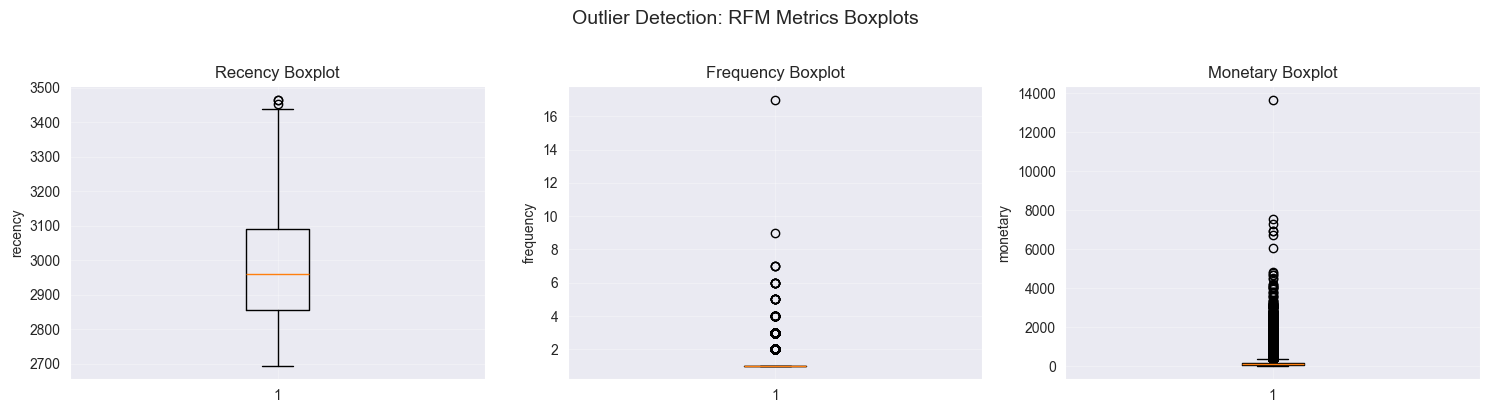


Note: Points beyond whiskers represent statistical outliers.
These are retained as they represent important user segments.


In [81]:
# Boxplot visualization of outliers
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(['recency', 'frequency', 'monetary']):
    axes[i].boxplot(df_rfm_check[col])
    axes[i].set_title(f"{col.capitalize()} Boxplot")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Outlier Detection: RFM Metrics Boxplots", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nNote: Points beyond whiskers represent statistical outliers.")
print("These are retained as they represent important user segments.")

In [82]:
# find frequency always are 1
df_rfm['frequency'].describe()

count    96219.000000
mean         1.033486
std          0.210763
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: frequency, dtype: float64

In [83]:
df_rfm['frequency'].value_counts().sort_index()

frequency
1     93333
2      2644
3       195
4        28
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

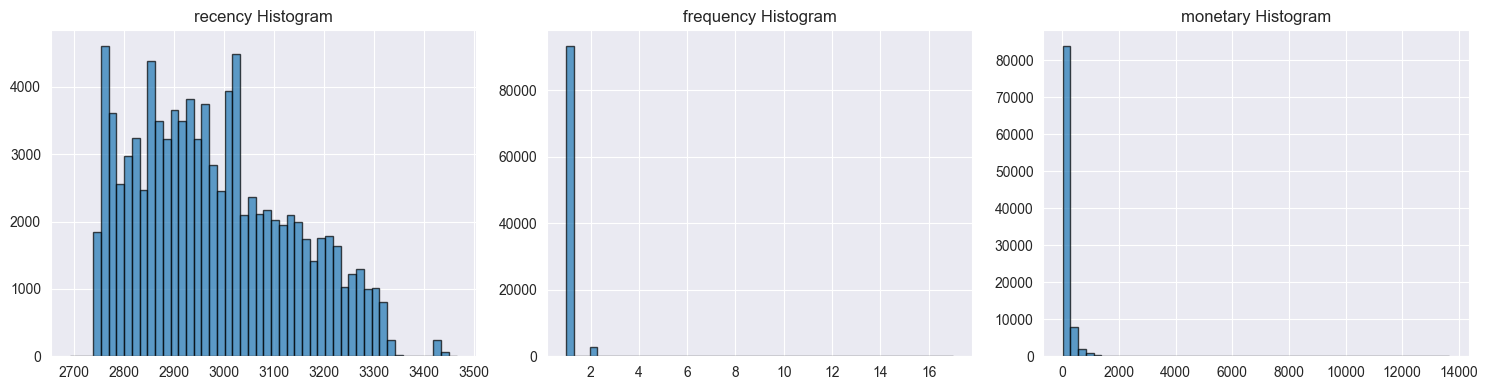

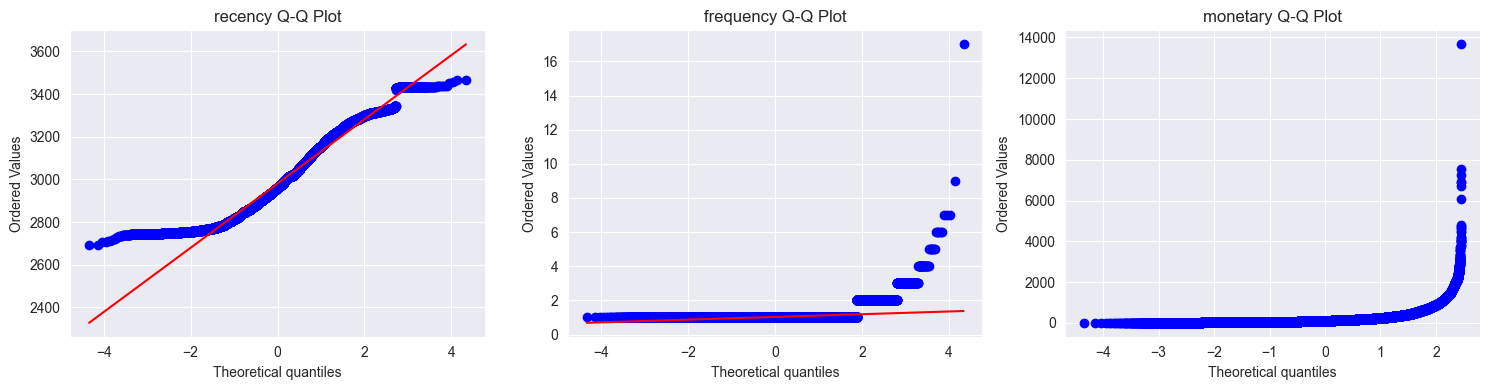

In [84]:
# RFM Distribution Exploration
import matplotlib.pyplot as plt
from scipy import stats

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['recency', 'frequency', 'monetary']):
    df_rfm[col].hist(
        bins=50,
        ax=axes[i],
        alpha=0.7,
        edgecolor='black'
    )
    axes[i].set_title(f"{col} Histogram")
plt.tight_layout()
plt.show()

# Q-Q plots for normality check
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['recency', 'frequency', 'monetary']):
    stats.probplot(df_rfm[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"{col} Q-Q Plot")
plt.tight_layout()
plt.show()

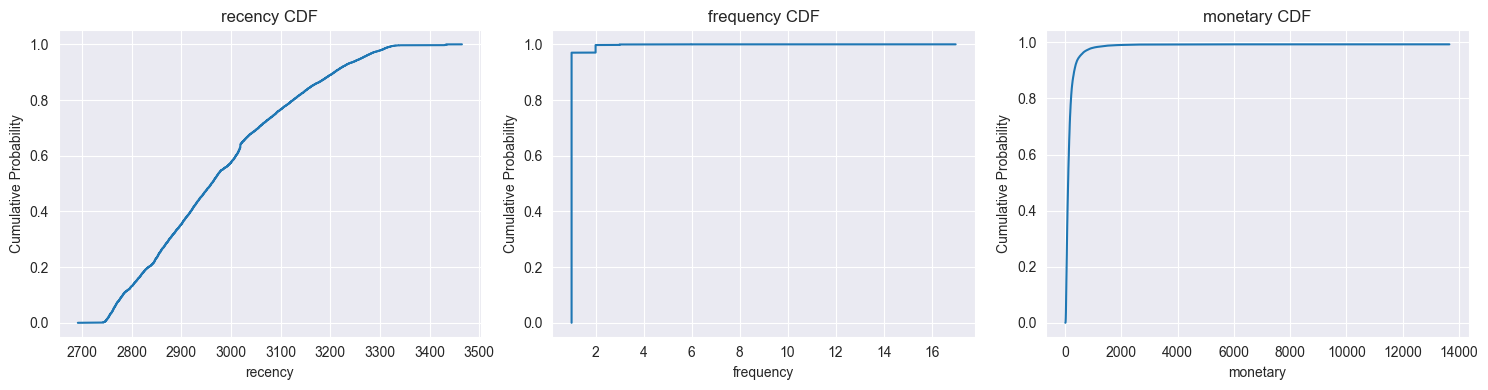

In [85]:
# CDF
import numpy as np
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['recency', 'frequency', 'monetary']):
    sorted_data = np.sort(df_rfm[col])
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    axes[i].plot(sorted_data, cdf)
    axes[i].set_title(f"{col} CDF")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Cumulative Probability")
plt.tight_layout()
plt.show()

## 3. RFM Metric Construction & Scoring

We apply a refined RFM scoring logic that addresses the extreme skewness in frequency distribution. The scoring system uses quantile-based binning and introduces a weighted RFM score to better reflect business priorities.

### 3.1 Initial RFM Scoring Attempt (Commented Out)

Below is the initial RFM scoring logic that was later refined. This version had inconsistent label directions and did not address the frequency skewness issue. It is preserved here to show the project evolution process.

In [86]:
# df_rfm = df_rfm.dropna#     subset=['recency', 'frequency', 'monetary'# ).copy(# # Recency scoring: The more recent the event, the higher the score# ''# qcut will be divided into 5 parts according to the value from smallest to larger, here directly specify the tag [5,4,3,2,1], so that the most recent one gets 5 point# ''# df_rfm['R_score'] = pd.qcut#     df_rfm['recency'],
#     5,
#     labels = [5, 4, 3, 2, 1]
# ).astype(int)
#
# # Frequency scoring: more bigger, the higher score
# '''
# Rank first, then qcut to avoid too many duplicate values causing qcut errors
# '''
# df_rfm['F_score'] = pd.qcut(
#     df_rfm['frequency'].rank(method='first'),
#     5,
#     labels=[5, 4, 3, 2, 1]
# ).astype(int)
#
# # Monetary:bigger, better
# df_rfm['M_score'] = pd.qcut(
#     df_rfm['monetary'].rank(method='first'),
#     5,
#     labels=[1, 2, 3, 4, 5]
# ).astype(int)
#
# # Simple total RFM score (3~15)
# df_rfm['RFM_score'] = (
#     df_rfm['R_score'] + df_rfm['F_score'] + df_rfm['M_score']
# )
#
# df_rfm[['unique_user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']].head(20)

### 3.1 Refined RFM Scoring (Current Version)

The improved version below addresses the issues identified above.

In [87]:
# Correction and enhancement of RFM scoring logic
df_rfm = df_rfm.dropna(
    subset=['recency', 'frequency', 'monetary']
).copy()
# Recency scoring: The more recent the event, the higher the score.
'''
qcut will be divided into 5 parts according to the value from smallest to larger, here directly specify the tag [5,4,3,2,1], so that the most recent one gets 5 points
'''
df_rfm['R_score'] = pd.qcut(
    df_rfm['recency'],
    5,
    labels = [5, 4, 3, 2, 1]
).astype(int)

# Frequency scoring:Extreme tilt problem handling + scoring
df_rfm['is_repeat_customer'] = (df_rfm['frequency'] >=2).astype(int)
'''
The vast majority of users have frequency=1, and the segmentation rule is used here:
All users with frequency == 1 are uniformly given F_score = 1
For users with frequency >= 2, give 2~5 points according to the quantile
'''
df_rfm['F_score'] = 1 # First, set the default value.

mask_repeat = df_rfm['frequency'] >= 2
df_repeat = df_rfm.loc[mask_repeat].copy()

if not df_repeat.empty and df_repeat['frequency'].nunique() > 1:
    df_rfm.loc[mask_repeat, 'F_score'] = pd.qcut(
        df_repeat['frequency'].rank(method='first'),
        4,  # four box: 2, 3, 4, 5 score
        labels=[2, 3, 4, 5]
    ).astype(int).values
else:
# Provision for extreme scenarios (for example, in cases where no customers re-purchase the product at all)
    df_rfm['F_score'] = 1

# Monetary:bigger, better
df_rfm['M_score'] = pd.qcut(
    df_rfm['monetary'].rank(method='first'),
    5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# Simple total RFM score (3~15)--Keep an original copy for easy comparison with traditional rfm
df_rfm['RFM_score_simple'] = (
    df_rfm['R_score'] + df_rfm['F_score'] + df_rfm['M_score']
)

# Weighted RFM score: decrease F, increase the weight of M
# RFM_score_weighted = 0.4 * R + 0.1 * F + 0.5 * M
df_rfm['RFM_score_weighted'] = (
    0.4 * df_rfm['R_score'] +
    0.1 * df_rfm['F_score'] +
    0.5 * df_rfm['M_score']
).round(2)


df_rfm[['unique_user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score_simple', 'RFM_score_weighted', 'is_repeat_customer']].head(20)

,unique_user_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score_simple,RFM_score_weighted,is_repeat_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,2852,1,141.90,4,1,4,9,3.7,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2855,1,27.19,4,1,1,6,2.2,0
2,0000f46a3911fa3c0805444483337064,3278,1,86.22,1,1,2,4,1.5,0
3,0000f6ccb0745a6a4b88665a16c9f078,3062,1,43.62,2,1,1,4,1.4,0
4,0004aac84e0df4da2b147fca70cf8255,3029,1,196.89,2,1,4,7,2.9,0
5,0004bd2a26a76fe21f786e4fbd80607f,2887,1,166.98,4,1,4,9,3.7,0
6,00050ab1314c0e55a6ca13cf7181fecf,2872,1,35.38,4,1,1,6,2.2,0
7,00053a61a98854899e70ed204dd4bafe,2923,1,419.18,3,1,5,9,3.8,0
8,0005e1862207bf6ccc02e4228effd9a0,3284,1,150.12,1,1,4,6,2.5,0
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2911,1,129.76,4,1,3,8,3.2,0


In [88]:
# EDA cell（check R/F/M score）
print("R_score distribution:\n", df_rfm['R_score'].value_counts().sort_index())
print("\nF_score distribution:\n", df_rfm['F_score'].value_counts().sort_index())
print("\nM_score distribution:\n", df_rfm['M_score'].value_counts().sort_index())
print("\nis_repeat_customer:\n", df_rfm['is_repeat_customer'].value_counts(normalize=True))

R_score distribution:
 R_score
1    18985
2    19184
3    19137
4    19008
5    19225
Name: count, dtype: int64

F_score distribution:
 F_score
1    92661
2      720
3      719
4      719
5      720
Name: count, dtype: int64

M_score distribution:
 M_score
1    19108
2    19108
3    19107
4    19108
5    19108
Name: count, dtype: int64

is_repeat_customer:
 is_repeat_customer
0    0.969876
1    0.030124
Name: proportion, dtype: float64


## 4. Clustering Analysis Preparation

Before clustering, we define configuration parameters and evaluation functions, then standardize the RFM features to ensure equal weighting in distance calculations.

In [89]:
# Create a new configuration + function
CONFIG = {
    'n_clusters': 3,
    'random_state': 42,
    'rfm_bins': 5,
    'churn_threshold': 365
}

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)
import numpy as np

def evaluate_clustering(x, labels):
    """
    Evaluate clustering quality with multiple indices.
    """

    return {
        'silhouette_score': silhouette_score(x, labels),
        'davies_bouldin': davies_bouldin_score(x, labels),
        'calinski_harabasz': calinski_harabasz_score(x, labels)
    }

In [90]:
# Select the features that will be used for clustering.
features = ['recency', 'frequency', 'monetary']

# standardscaler(All variables become the same scale.)
from sklearn.preprocessing import StandardScaler

x = df_rfm[features]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

## 5. Clustering Model Selection & Evaluation

We use the Elbow Method and Silhouette Score to determine the optimal number of clusters, then assess clustering quality through multiple metrics including Davies-Bouldin Index and stability testing.

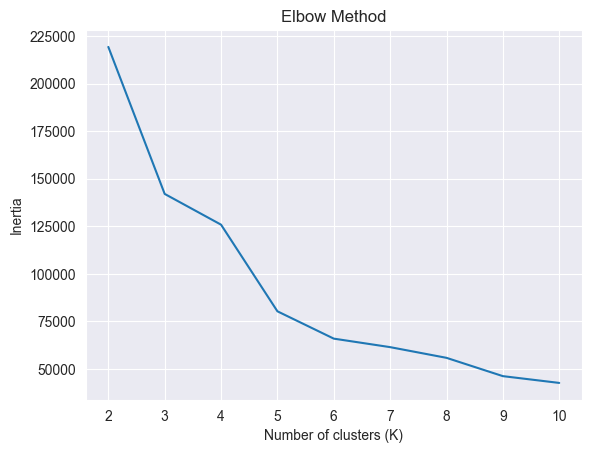

In [91]:
# K value
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Elbow Method map analysis
The Elbow curve shows a continuous decrease in inertia from K=2 to K=5, with a particularly noticeable drop between K=4 and K=5. After K=5, the rate of decrease slows significantly and the curve begins to flatten.

This suggests that adding clusters beyond K=5 yields diminishing returns in terms of reducing within-cluster variance.

Therefore, from an inertia minimization perspective, K=5 appears to be a potential elbow point.

In [92]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.4028
K=3, Silhouette Score=0.4557
K=4, Silhouette Score=0.3613
K=5, Silhouette Score=0.4177
K=6, Silhouette Score=0.4361
K=7, Silhouette Score=0.3790
K=8, Silhouette Score=0.3933
K=9, Silhouette Score=0.3957
K=10, Silhouette Score=0.3989


# Cluster Selection Summary (Elbow + Silhouette Combined)
Based on the Silhouette evaluation from K=2 to K=10, the highest score occurs at K=3 (0.4557), indicating the clearest structural separation and strongest cluster cohesion.

Although higher K values such as K=5 (0.4177) and K=6 (0.4361) provide additional segmentation granularity, their separation quality is slightly weaker compared to K=3. Scores beyond K=6 begin to stabilize around 0.38–0.39, suggesting diminishing structural improvement and potential over-segmentation.

Combined with the Elbow analysis, which shows noticeable inertia reduction around K=5, we observe a trade-off between statistical compactness and structural clarity.

From a purely statistical standpoint, K=3 is the most robust segmentation choice.
However, depending on business needs for finer differentiation, K=5 may serve as a practical alternative.

### 6.1 Initial Clustering Attempt (Commented Out)

Below is the initial simple clustering code that was later enhanced with quality metrics and stability testing. It is preserved here to show the iterative improvement process.

In [93]:
# kmeans = KMeans(n_clusters=3, random_state=42)
# df_rfm['cluster'] = kmeans.fit_predict(x_scaled)

### 6.2 Enhanced Clustering with Quality Evaluation (Current Version)

The improved version below includes quality metrics and stability testing.

In [94]:
# Updated with a more complete "Quality + Stability" analysis.
# Final clustering with K-Means
kmeans = KMeans(
    n_clusters=CONFIG['n_clusters'],
    random_state=CONFIG['random_state']
)
df_rfm['cluster'] = kmeans.fit_predict(x_scaled)

# Evaluate the current quality of the clustering.
cluster_metrics = evaluate_clustering(x_scaled, df_rfm['cluster'])
print("Clustering quanlity (K=3):")
for k, v in cluster_metrics.items():
    print(f" {k}: {v:.4f}")

Clustering quanlity (K=3):
 silhouette_score: 0.4557
 davies_bouldin: 0.7619
 calinski_harabasz: 48636.7004


In [95]:
# Cluster stability test: Consistency of results across different random_state
base_labels = df_rfm['cluster'].values

aris=[]
for seed in [10, 20, 30, 40, 50]:
    kmeans_tmp = KMeans(
        n_clusters=CONFIG['n_clusters'],
        random_state=seed
    )
    tmp_labels = kmeans_tmp.fit_predict(x_scaled)
    ari = adjusted_rand_score(base_labels, tmp_labels)
    aris.append(ari)
    print(f"Seed {seed}: Adjusted Rand Index = {ari:.4f}")

print(f"\nAverage ARI across seeds = {np.mean(aris):.4f}")

Seed 10: Adjusted Rand Index = 0.9956
Seed 20: Adjusted Rand Index = 0.9891
Seed 30: Adjusted Rand Index = 0.9968
Seed 40: Adjusted Rand Index = 0.9959
Seed 50: Adjusted Rand Index = 0.9998

Average ARI across seeds = 0.9954


**ARI consistently above 0.9 indicates that the K-Means solution is stable with respect to random initialization.**

## 7. Statistical Analysis of Clustering Results

We examine cluster characteristics through descriptive statistics and validate the statistical significance of differences between clusters using non-parametric tests (Kruskal-Wallis, Mann-Whitney U) and chi-square test for geographic distribution.

In [96]:
# how many person in each cluster
df_rfm['cluster'].value_counts().sort_index()

cluster
0    39363
1    53291
2     2885
Name: count, dtype: int64

In [97]:
# rfm.mean for each cluster
cluster_profile = df_rfm.groupby('cluster')[
    ['recency', 'frequency', 'monetary']
].mean().round(2)

cluster_profile

,recency,frequency,monetary
cluster,,,
0,3129.80,1.00,162.27
1,2869.59,1.00,159.81
2,2962.04,2.11,325.69


In [98]:
# cluster_size
cluster_size = df_rfm['cluster'].value_counts(normalize=True).sort_index()
cluster_size

cluster
0    0.412010
1    0.557793
2    0.030197
Name: proportion, dtype: float64

In [99]:
# Combine cluster size & RFM profile into one table
cluster_profile_with_size = cluster_profile.copy()
cluster_profile_with_size["user_count"] = df_rfm["cluster"].value_counts().sort_index()
cluster_profile_with_size["user_ratio"] = df_rfm["cluster"].value_counts(normalize=True).sort_index().round(4)
cluster_profile_with_size

,recency,frequency,monetary,user_count,user_ratio
cluster,,,,,
0,3129.80,1.00,162.27,39363,0.4120
1,2869.59,1.00,159.81,53291,0.5578
2,2962.04,2.11,325.69,2885,0.0302


In [100]:
# Statistical Tests for Cluster Differences
from scipy.stats import kruskal, mannwhitneyu
# Kruskal-Wallis for R\F\M
rfm_cols = ['recency', 'frequency', 'monetary']
for col in rfm_cols:
    groups = [
        df_rfm.loc[df_rfm['cluster'] == c, col]
        for c in sorted(df_rfm['cluster'].unique())
    ]
    stat, p = kruskal(*groups)
    print(f"[Kruskal-Wallis] {col}: H={stat:.4f}, p={p:.4e}")

# Customer lifetime days differences
groups_lifetime = [
    df_rfm.loc[df_rfm['cluster'] == c, 'customer_lifetime_days']
    for c in sorted(df_rfm['cluster'].unique())
]
stat, p = kruskal(*groups_lifetime)
print(f"\n[Kruskal-Wallis] customer_lifetime_days: H={stat:.4f}, p={p:.4e}")

[Kruskal-Wallis] recency: H=67989.9210, p=0.0000e+00
[Kruskal-Wallis] frequency: H=95292.1431, p=0.0000e+00
[Kruskal-Wallis] monetary: H=2366.6007, p=0.0000e+00

[Kruskal-Wallis] customer_lifetime_days: H=67001.5724, p=0.0000e+00


In [101]:
# Pairwise Mann-Whitney U tests with Bonferroni correction
clusters = sorted(df_rfm['cluster'].unique())
alpha = 0.05
m = len(clusters) * (len(clusters) - 1) / 2  # number of comparisons
alpha_bonf = alpha / m

print(f"Bonferroni-corrected alpha = {alpha_bonf:.4f}\n")

for col in rfm_cols:
    print(f"--- Pairwise Mann-Whitney for {col} ---")
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            c1, c2 = clusters[i], clusters[j]
            g1 = df_rfm.loc[df_rfm['cluster'] == c1, col]
            g2 = df_rfm.loc[df_rfm['cluster'] == c2, col]
            stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
            sig = "SIGNIFICANT" if p < alpha_bonf else "ns"
            print(f"Cluster {c1} vs {c2}: U={stat:.0f}, p={p:.4e} ({sig})")
    print()

Bonferroni-corrected alpha = 0.0167

--- Pairwise Mann-Whitney for recency ---
Cluster 0 vs 1: U=2097677030, p=0.0000e+00 (SIGNIFICANT)
Cluster 0 vs 2: U=93347550, p=0.0000e+00 (SIGNIFICANT)
Cluster 1 vs 2: U=48788417, p=2.6594e-240 (SIGNIFICANT)

--- Pairwise Mann-Whitney for frequency ---
Cluster 0 vs 1: U=1048846816, p=1.0000e+00 (ns)
Cluster 0 vs 2: U=137770, p=0.0000e+00 (SIGNIFICANT)
Cluster 1 vs 2: U=186518, p=0.0000e+00 (SIGNIFICANT)

--- Pairwise Mann-Whitney for monetary ---
Cluster 0 vs 1: U=1045429160, p=3.9577e-01 (ns)
Cluster 0 vs 2: U=26664847, p=0.0000e+00 (SIGNIFICANT)
Cluster 1 vs 2: U=36029413, p=0.0000e+00 (SIGNIFICANT)



In [102]:
# RFM_score vs Monetary
from scipy.stats import spearmanr

# Spearman correlation between RFM scores and monetary value
rho_simple, p_simple = spearmanr(df_rfm['RFM_score_simple'], df_rfm['monetary'])
rho_weighted, p_weighted = spearmanr(df_rfm['RFM_score_weighted'], df_rfm['monetary'])

print(f"Spearman (simple RFM vs monetary): rho={rho_simple:.4f}, p={p_simple:.4e}")
print(f"Spearman (weighted RFM vs monetary): rho={rho_weighted:.4f}, p={p_weighted:.4e}")

Spearman (simple RFM vs monetary): rho=0.6978, p=0.0000e+00
Spearman (weighted RFM vs monetary): rho=0.7826, p=0.0000e+00


**If rho > 0.6, it indicates that the RFM score is indeed capable of distinguishing the value of different users.**

In [103]:
# Geographic Distribution vs Cluster
from scipy.stats import chi2_contingency

crosstab_state_cluster = pd.crosstab(df_rfm['state'], df_rfm['cluster'])
chi2, p, dof, expected = chi2_contingency(crosstab_state_cluster)

print("Chi-square test for state vs. cluster")
print(f"chi2={chi2:.4f}, dof={dof}, p={p:.4e}")

Chi-square test for state vs. cluster
chi2=364.8234, dof=52, p=1.5096e-48


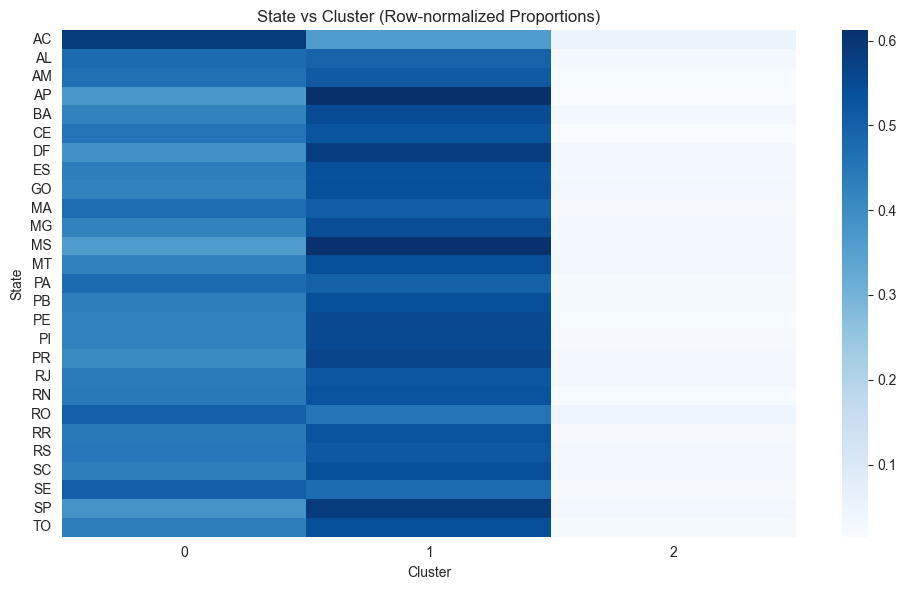

In [104]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(
    crosstab_state_cluster.apply(lambda r: r / r.sum(), axis=1),
    annot=False,
    cmap='Blues'
)
plt.title("State vs Cluster (Row-normalized Proportions)")
plt.xlabel("Cluster")
plt.ylabel("State")
plt.tight_layout()
plt.show()


## 8. Cluster Visualization

Multiple visualization techniques help us understand cluster separation and characteristics in different dimensional spaces.

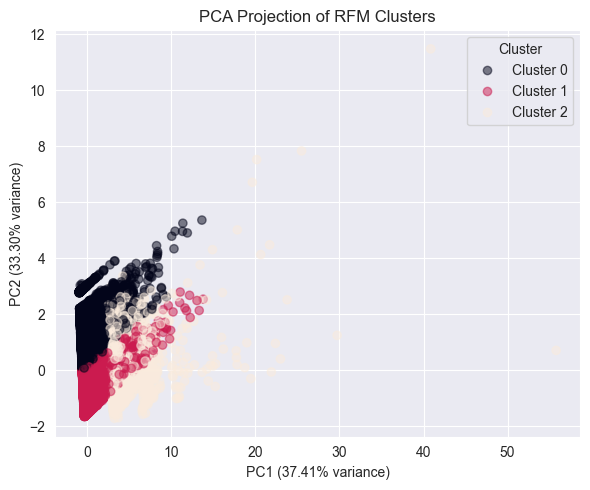

In [105]:
# PCA Visualization of Clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=CONFIG['random_state'])
x_pca = pca.fit_transform(x_scaled)

df_rfm['pca1'] = x_pca[:, 0]
df_rfm['pca2'] = x_pca[:, 1]

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    df_rfm['pca1'],
    df_rfm['pca2'],
    c=df_rfm['cluster'],
    alpha=0.5
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.title("PCA Projection of RFM Clusters")
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[f"Cluster {c}" for c in sorted(df_rfm['cluster'].unique())],
    title="Cluster"
)
plt.tight_layout()
plt.show()

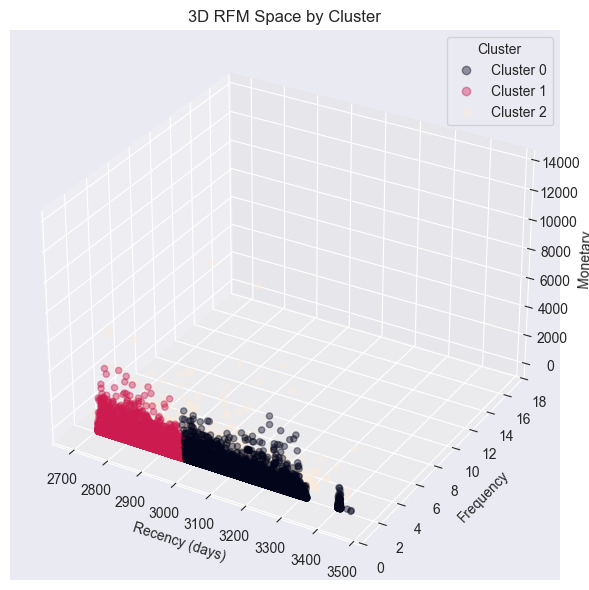

In [106]:
# 3D R\F\M scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_rfm['recency'],
    df_rfm['frequency'],
    df_rfm['monetary'],
    c=df_rfm['cluster'],
    alpha=0.4
)
ax.set_xlabel("Recency (days)")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D RFM Space by Cluster")
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[f"Cluster {c}" for c in sorted(df_rfm['cluster'].unique())],
    title="Cluster"
)
plt.tight_layout()
plt.show()

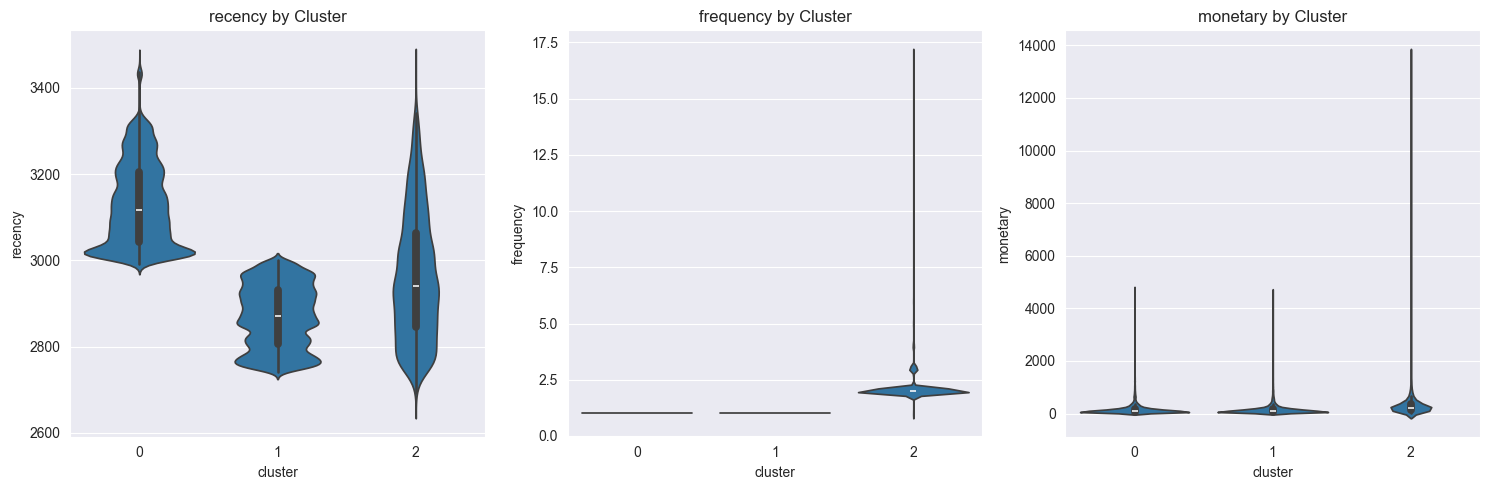

In [107]:
# Violin Plot ( R/F/M distribution by cluster)
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['recency', 'frequency', 'monetary']):
    sns.violinplot(
        x='cluster',
        y=col,
        data=df_rfm,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} by Cluster")
plt.tight_layout()
plt.show()


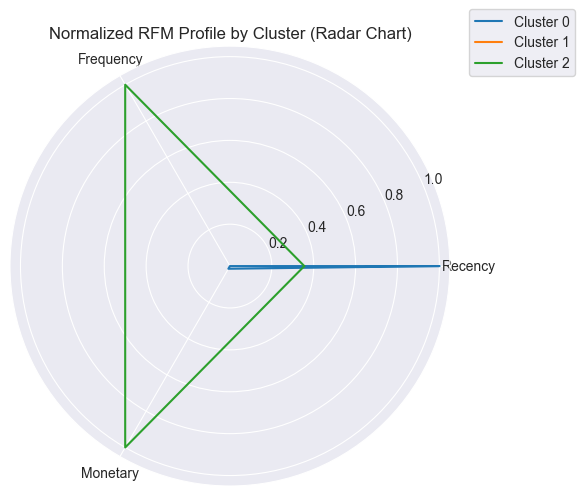

In [108]:
# Radar chart for cluster profiles
import numpy as np
from math import pi

categories = ['Recency', 'Frequency', 'Monetary']
N = len(categories)

# standard cluster_profile
cluster_profile_norm = (
    cluster_profile - cluster_profile.min()
) / (cluster_profile.max() - cluster_profile.min())

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(6, 6))
for c in sorted(cluster_profile_norm.index):
    values = cluster_profile_norm.loc[c, ['recency', 'frequency', 'monetary']].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {c}")

plt.xticks(angles[:-1], categories)
plt.title("Normalized RFM Profile by Cluster (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

## 9. User Segmentation & Business Value Analysis

We translate statistical clusters into actionable business segments, quantify their value contribution, and develop targeted strategies for each segment.

In [109]:
# Map cluster id to human-readable segment names
cluster_labels = {
    0: "Lapsed Single-Purchase Users",
    1: "Recent Single-Purchase Users",
    2: "High-Value Repeat Customers"
}

df_rfm["segment"] = df_rfm["cluster"].map(cluster_labels)

df_rfm[["unique_user_id", "cluster", "segment", "recency", "frequency", "monetary"]].head(10)

,unique_user_id,cluster,segment,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,Recent Single-Purchase Users,2852,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,Recent Single-Purchase Users,2855,1,27.19
2,0000f46a3911fa3c0805444483337064,0,Lapsed Single-Purchase Users,3278,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,0,Lapsed Single-Purchase Users,3062,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,0,Lapsed Single-Purchase Users,3029,1,196.89
5,0004bd2a26a76fe21f786e4fbd80607f,1,Recent Single-Purchase Users,2887,1,166.98
6,00050ab1314c0e55a6ca13cf7181fecf,1,Recent Single-Purchase Users,2872,1,35.38
7,00053a61a98854899e70ed204dd4bafe,1,Recent Single-Purchase Users,2923,1,419.18
8,0005e1862207bf6ccc02e4228effd9a0,0,Lapsed Single-Purchase Users,3284,1,150.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,1,Recent Single-Purchase Users,2911,1,129.76


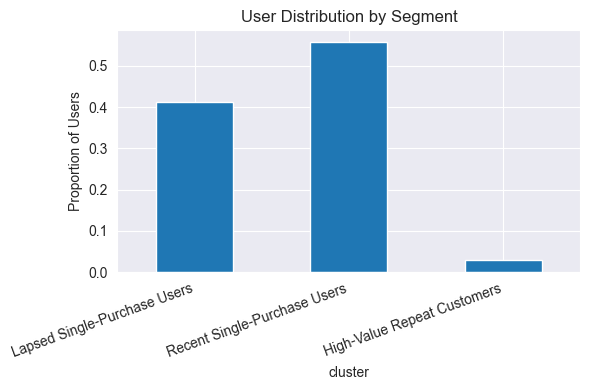

In [110]:
import matplotlib.pyplot as plt

# Visualization 1: Proportion of users in each segment
plt.figure(figsize=(6, 4))
cluster_profile_with_size["user_ratio"].plot(kind="bar")
plt.xticks(
    range(len(cluster_profile_with_size)),
    [cluster_labels[i] for i in cluster_profile_with_size.index],
    rotation=20,
    ha="right"
)

plt.ylabel("Proportion of Users")
plt.title("User Distribution by Segment")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

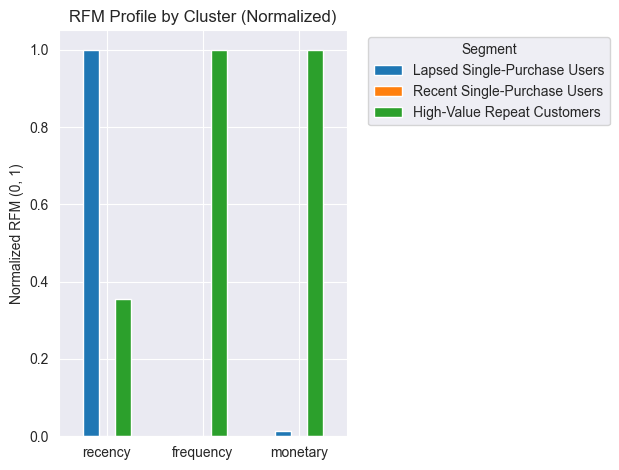

In [111]:
# Visualization 2: Standardized RFM images for each segment
rfm_profile_norm =(cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

plt.figure(figsize=(8, 5))
rfm_profile_norm.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Normalized RFM (0, 1)")
plt.title("RFM Profile by Cluster (Normalized)")
plt.legend(
    [cluster_labels[i] for i in rfm_profile_norm.index],
    title="Segment",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

# Segment Definition & Business Interpretation

**Cluster 1 – Recent Single-Purchase Users (~55.8%)**
  - Characteristics: most recent purchases (lowest recency), single-order , medium spend.
  - Business view: newcomers or recently activated users with limited purchase history.
  - Strategy: welcome offers, cross-sell recommendations, onboarding journeys to drive second purchase.

**Cluster 0 – Lapsed Single-Purchase Users (~41.2%)**
  - Characteristics: long time since last purchase (highest recency), still mostly single-order, moderate spend.
  - Business view: churn-risk / sleeping users who have purchased once but did not come back.
  - Strategy: reactivation campaigns, time-limited discounts, win-back emails highlighting category they bought before.

**Cluster 2 – High-Value Repeat Customers (~3.0%)**
  - Characteristics: significantly higher frequency and monetary value, recency in the middle range.
  - Business view: core loyal customers contributing disproportionately to GMV.
  - Strategy: loyalty programs, VIP service, early access to promotions, personalized recommendations.

In [112]:
# User Value Contribution Analysis
value_analysis = df_rfm.groupby('cluster').agg({
    'monetary': ['sum', 'mean', 'median'],
    'unique_user_id': 'count'
}).round(2)

value_analysis.columns = ['monetary_sum', 'monetary_mean', 'monetary_median', 'user_count']

value_analysis['gmv_ratio'] = (
    value_analysis['monetary_sum'] / value_analysis['monetary_sum'].sum()
).round(4)

value_analysis['user_ratio'] = (
    value_analysis['user_count'] / value_analysis['user_count'].sum()
).round(4)

value_analysis

,monetary_sum,monetary_mean,monetary_median,user_count,gmv_ratio,user_ratio
cluster,,,,,,
0,6387562.74,162.27,104.79,39363,0.4032,0.4120
1,8516369.23,159.81,106.70,53291,0.5375,0.5578
2,939621.27,325.69,223.10,2885,0.0593,0.0302


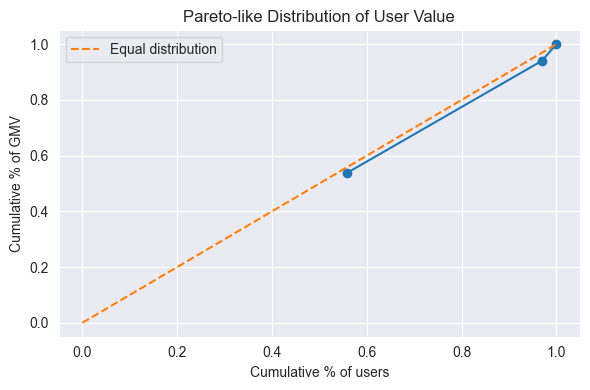

In [113]:
# Sort clusters by GMV contribution (descending)
sorted_va = value_analysis.sort_values('monetary_sum', ascending=False)

sorted_va['gmv_cumsum'] = sorted_va['gmv_ratio'].cumsum()
sorted_va['user_cumsum'] = sorted_va['user_ratio'].cumsum()

plt.figure(figsize=(6, 4))
plt.plot(sorted_va['user_cumsum'], sorted_va['gmv_cumsum'], marker='o')
plt.plot([0, 1], [0, 1], '--', label='Equal distribution')
plt.xlabel("Cumulative % of users")
plt.ylabel("Cumulative % of GMV")
plt.title("Pareto-like Distribution of User Value")
plt.legend()
plt.tight_layout()
plt.show()


In [114]:
# Churn Risk & Potential Recovery
# Use the 75% quantile as the threshold for "high recency=high risk of attrition"
churn_threshold = df_rfm['recency'].quantile(0.75)
print("Churn threshold (75th percentile of recency):", churn_threshold)

df_rfm['is_churned'] = (df_rfm['recency'] >= churn_threshold).astype(int)

churn_rate_by_cluster = df_rfm.groupby('cluster')['is_churned'].mean().round(4)
print("Churn rate by cluster:\n", churn_rate_by_cluster)

# Estimate the potential GMV from recovering 10% of churned users (cluster 0 as an example)
cluster_0 = df_rfm[df_rfm['cluster'] == 0]
cluster_0_churned = cluster_0[cluster_0['is_churned'] == 1]

recovered_users = len(cluster_0_churned) * 0.10
avg_value_churned = cluster_0_churned['monetary'].mean()

potential_revenue = recovered_users * avg_value_churned
print(f"\nEstimated GMV increase by recovering 10% of churned users in cluster 0: {potential_revenue:.2f}")

Churn threshold (75th percentile of recency): 3089.0
Churn rate by cluster:
 cluster
0    0.5924
1    0.0000
2    0.2121
Name: is_churned, dtype: float64

Estimated GMV increase by recovering 10% of churned users in cluster 0: 376440.11


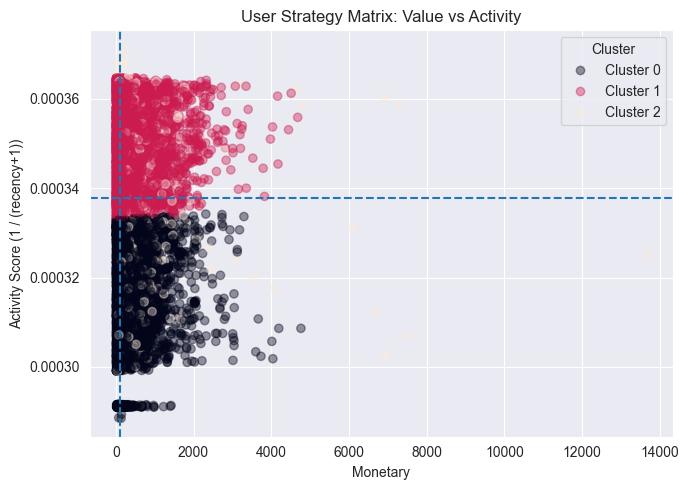

strategy
Low Priority               0.2562
VIP Retention              0.2540
High-Value Reactivation    0.2459
Potential Nurturing        0.2439
Name: proportion, dtype: float64

In [115]:
# Strategy Priority Matrix
df_rfm['activity_score'] = 1 / (df_rfm['recency'] + 1)

median_value = df_rfm['monetary'].median()
median_activity = df_rfm['activity_score'].median()

def categorize_user(row):
    if row['monetary'] > median_value and row['activity_score'] > median_activity:
        return 'VIP Retention'
    elif row['monetary'] > median_value and row['activity_score'] <= median_activity:
        return 'High-Value Reactivation'
    elif row['monetary'] <= median_value and row['activity_score'] > median_activity:
        return 'Potential Nurturing'
    else:
        return 'Low Priority'

df_rfm['strategy'] = df_rfm.apply(categorize_user, axis=1)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    df_rfm['monetary'],
    df_rfm['activity_score'],
    c=df_rfm['cluster'],
    alpha=0.4
)
plt.axvline(median_value, linestyle='--')
plt.axhline(median_activity, linestyle='--')
plt.xlabel("Monetary")
plt.ylabel("Activity Score (1 / (recency+1))")
plt.title("User Strategy Matrix: Value vs Activity")
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[f"Cluster {c}" for c in sorted(df_rfm['cluster'].unique())],
    title="Cluster"
)
plt.tight_layout()
plt.show()
# View the distribution of people by strategy type
df_rfm['strategy'].value_counts(normalize=True).round(4)

### 9.7 Save User Segmentation Results

The user segmentation results are saved for downstream applications in the machine learning layer, recommendation system, and business intelligence dashboards.

In [116]:
# Save user segmentation results for downstream use
import os

# Create output directory if it doesn't exist
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

# Prepare output DataFrame
output_df = df_rfm[[
    'unique_user_id',
    'cluster',
    'segment',
    'recency',
    'frequency',
    'monetary',
    'R_score',
    'F_score',
    'M_score',
    'RFM_score_simple',
    'RFM_score_weighted',
    'is_repeat_customer',
    'is_churned',
    'strategy'
]].copy()

# Save to CSV
output_path = os.path.join(output_dir, 'user_segments_rfm.csv')
output_df.to_csv(output_path, index=False)

print("=" * 60)
print("User Segmentation Results Saved")
print("=" * 60)
print(f"\n[OK] Saved to: {output_path}")
print(f"[OK] Total users: {len(output_df):,}")
print(f"[OK] Columns exported: {len(output_df.columns)}")
print(f"\nExported columns:")
for col in output_df.columns:
    print(f"  - {col}")

# Also save cluster centers for reference
cluster_centers_df = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=['recency', 'frequency', 'monetary']
)
cluster_centers_df.index.name = 'cluster'

centers_path = os.path.join(output_dir, 'cluster_centers.csv')
cluster_centers_df.to_csv(centers_path)

print(f"\n[OK] Cluster centers saved to: {centers_path}")
print("\nCluster Centers:")
print(cluster_centers_df)

print("\n" + "=" * 60)
print("These files will be used in:")
print("=" * 60)
print("1. Machine Learning Layer: Churn prediction features")
print("2. Recommendation System: Segment-based product recommendations")
print("3. Business Intelligence: Dashboards and reporting")
print("4. Marketing Automation: Campaign targeting and personalization")

User Segmentation Results Saved

[OK] Saved to: ../output\user_segments_rfm.csv
[OK] Total users: 95,539
[OK] Columns exported: 14

Exported columns:
  - unique_user_id
  - cluster
  - segment
  - recency
  - frequency
  - monetary
  - R_score
  - F_score
  - M_score
  - RFM_score_simple
  - RFM_score_weighted
  - is_repeat_customer
  - is_churned
  - strategy

[OK] Cluster centers saved to: ../output\cluster_centers.csv

Cluster Centers:
          recency  frequency  monetary
cluster                               
0        0.980701  -0.159208 -0.015556
1       -0.717960  -0.159208 -0.026449
2       -0.114609   5.113094  0.700845

These files will be used in:
1. Machine Learning Layer: Churn prediction features
2. Recommendation System: Segment-based product recommendations
3. Business Intelligence: Dashboards and reporting
4. Marketing Automation: Campaign targeting and personalization


## 10. Future Directions & Precision Marketing Framework

#  Experiment & LTV Framework (For Future Precision Marketing)
This section outlines an A/B testing framework for Cluster 1 (Recent Single-Purchase Users) and a simplified LTV estimation for Cluster 2 (High-Value Repeat Customers).1

### 10.1 A/B Testing Design for Cluster 1 (Recent Single-Purchase Users)

**Objective**: Increase repeat purchase rate from baseline 5% to 7% within 30 days

We design a controlled experiment to test different strategies for converting first-time buyers into repeat customers.

In [117]:
# A/B Testing: Sample Size Calculation
from statsmodels.stats.power import zt_ind_solve_power
import numpy as np

print("=" * 60)
print("A/B Test Sample Size Calculation")
print("=" * 60)

# Test parameters
baseline_rate = 0.05  # Current 5% repeat purchase rate
target_rate = 0.07    # Target 7% rate (40% relative lift)
effect_size = target_rate - baseline_rate
alpha = 0.05          # Significance level (5% Type I error)
power = 0.80          # Statistical power (80% chance to detect effect)

# Calculate required sample size per group
try:
    n_per_group = zt_ind_solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        alternative='larger'
    )
    n_per_group = int(np.ceil(n_per_group))
except:
    # Fallback calculation if zt_ind_solve_power fails
    # Using simplified formula
    z_alpha = 1.96  # for alpha=0.05
    z_beta = 0.84   # for power=0.80
    p_avg = (baseline_rate + target_rate) / 2
    n_per_group = int(np.ceil(
        ((z_alpha + z_beta) ** 2 * 2 * p_avg * (1 - p_avg)) / (effect_size ** 2)
    ))

n_groups = 4  # Control + 3 treatment groups
total_needed = n_per_group * n_groups

print(f"\nTest Parameters:")
print(f"  Baseline conversion rate: {baseline_rate:.1%}")
print(f"  Target conversion rate: {target_rate:.1%}")
print(f"  Minimum detectable effect: {effect_size:.1%} (absolute)")
print(f"  Relative lift: {(target_rate/baseline_rate - 1):.1%}")
print(f"  Significance level (α): {alpha}")
print(f"  Statistical power (1-β): {power}")

print(f"\nSample Size Requirements:")
print(f"  Per group: {n_per_group:,} users")
print(f"  Total (4 groups): {total_needed:,} users")

# Check feasibility
cluster_1_size = len(df_rfm[df_rfm['cluster'] == 1])
print(f"\nAvailable Users in Cluster 1: {cluster_1_size:,}")

if cluster_1_size >= total_needed:
    print(f"[OK] Feasibility: SUFFICIENT (Coverage: {cluster_1_size/total_needed:.1f}x)")
else:
    print(f"[WARNING] Feasibility: INSUFFICIENT (Need {total_needed - cluster_1_size:,} more users)")
    print("         Consider reducing number of groups or accepting lower power")

A/B Test Sample Size Calculation

Test Parameters:
  Baseline conversion rate: 5.0%
  Target conversion rate: 7.0%
  Minimum detectable effect: 2.0% (absolute)
  Relative lift: 40.0%
  Significance level (α): 0.05
  Statistical power (1-β): 0.8

Sample Size Requirements:
  Per group: 30,913 users
  Total (4 groups): 123,652 users

Available Users in Cluster 1: 53,291
[WARNING] Feasibility: INSUFFICIENT (Need 70,361 more users)
         Consider reducing number of groups or accepting lower power


In [118]:
# A/B Test Experiment Design
print("\n" + "=" * 60)
print("Experiment Group Design")
print("=" * 60)

experiment_groups = {
    'Control': {
        'allocation': '25%',
        'treatment': 'No intervention (baseline)',
        'channel': 'Normal flow',
        'message': None
    },
    'Group A': {
        'allocation': '25%',
        'treatment': '10% discount coupon for 2nd order',
        'channel': 'Email + In-app notification',
        'message': '"Complete your 2nd order within 7 days, get 10% off!"'
    },
    'Group B': {
        'allocation': '25%',
        'treatment': 'Personalized product recommendations',
        'channel': 'Email with ML-based recommendations',
        'message': '"Based on your purchase, you might also like..."'
    },
    'Group C': {
        'allocation': '25%',
        'treatment': 'Discount + Recommendations (Combined)',
        'channel': 'Email with coupon + recommendations',
        'message': '"10% off + products picked just for you!"'
    }
}

for group, details in experiment_groups.items():
    print(f"\n{group} ({details['allocation']}):")
    print(f"  Treatment: {details['treatment']}")
    print(f"  Channel: {details['channel']}")
    if details['message']:
        print(f"  Message: {details['message']}")

print("\n" + "=" * 60)
print("Success Metrics")
print("=" * 60)
print("\nPrimary Metric:")
print("  - 30-day repeat purchase rate")
print("\nSecondary Metrics:")
print("  - Average order value (AOV) of 2nd purchase")
print("  - Time to 2nd purchase (days)")
print("  - Customer acquisition cost (CAC) ratio")
print("  - Return on investment (ROI)")

print("\n" + "=" * 60)
print("Expected Business Impact")
print("=" * 60)

# Calculate potential revenue
avg_second_order = df_rfm[df_rfm['frequency'] >= 2]['monetary'].mean() / 2
incremental_users = cluster_1_size * (target_rate - baseline_rate)
incremental_revenue = incremental_users * avg_second_order

print(f"\nIf successful (reaching {target_rate:.1%} conversion):")
print(f"  Incremental conversions: {incremental_users:,.0f} users")
print(f"  Avg 2nd order value: ${avg_second_order:,.2f}")
print(f"  Incremental revenue: ${incremental_revenue:,.2f}")

# Cost estimate
cost_per_user = 5  # Estimated cost (coupon + ops)
total_cost = cluster_1_size * 0.75 * cost_per_user  # 75% get treatment
roi = (incremental_revenue - total_cost) / total_cost * 100

print(f"\nCost Analysis:")
print(f"  Estimated cost per treated user: ${cost_per_user}")
print(f"  Total campaign cost: ${total_cost:,.2f}")
print(f"  Expected ROI: {roi:,.1f}%")


Experiment Group Design

Control (25%):
  Treatment: No intervention (baseline)
  Channel: Normal flow

Group A (25%):
  Treatment: 10% discount coupon for 2nd order
  Channel: Email + In-app notification
  Message: "Complete your 2nd order within 7 days, get 10% off!"

Group B (25%):
  Treatment: Personalized product recommendations
  Channel: Email with ML-based recommendations
  Message: "Based on your purchase, you might also like..."

Group C (25%):
  Treatment: Discount + Recommendations (Combined)
  Channel: Email with coupon + recommendations
  Message: "10% off + products picked just for you!"

Success Metrics

Primary Metric:
  - 30-day repeat purchase rate

Secondary Metrics:
  - Average order value (AOV) of 2nd purchase
  - Time to 2nd purchase (days)
  - Customer acquisition cost (CAC) ratio
  - Return on investment (ROI)

Expected Business Impact

If successful (reaching 7.0% conversion):
  Incremental conversions: 1,066 users
  Avg 2nd order value: $154.14
  Incremental

### 10.2 Customer Lifetime Value (LTV) Estimation

For Cluster 2 (High-Value Repeat Customers), we estimate LTV to justify retention program investments and guide resource allocation.

In [119]:
# Customer Lifetime Value (LTV) Estimation for Cluster 2
print("=" * 60)
print("LTV Estimation: Cluster 2 (High-Value Repeat Customers)")
print("=" * 60)

# Filter Cluster 2 data
cluster_2_data = df_rfm[df_rfm['cluster'] == 2].copy()

print(f"\nCluster 2 Profile:")
print(f"  Total users: {len(cluster_2_data):,}")
print(f"  Percentage of total: {len(cluster_2_data)/len(df_rfm)*100:.2f}%")

# Calculate LTV components
avg_order_value = (cluster_2_data['monetary'] / cluster_2_data['frequency']).mean()
avg_frequency = cluster_2_data['frequency'].mean()
avg_lifetime_days = cluster_2_data['customer_lifetime_days'].mean()

# Estimate annual purchase frequency
if avg_lifetime_days > 0:
    annual_frequency = avg_frequency / (avg_lifetime_days / 365)
else:
    annual_frequency = avg_frequency  # Single year assumption

# LTV assumptions
expected_lifespan_years = 3  # Industry standard for e-commerce
retention_rate = 0.75  # Estimated 75% annual retention
discount_rate = 0.10  # 10% discount rate for future value

print(f"\nLTV Components (Historical Data):")
print(f"  Average Order Value (AOV): ${avg_order_value:.2f}")
print(f"  Average Purchase Frequency: {avg_frequency:.2f} orders")
print(f"  Average Customer Lifetime: {avg_lifetime_days:.0f} days")
print(f"  Estimated Annual Frequency: {annual_frequency:.2f} orders/year")

# Simple LTV calculation
ltv_simple = avg_order_value * annual_frequency * expected_lifespan_years

# Adjusted LTV with retention
ltv_adjusted = 0
for year in range(1, expected_lifespan_years + 1):
    retention_factor = retention_rate ** (year - 1)
    discount_factor = (1 + discount_rate) ** (-year)
    annual_value = avg_order_value * annual_frequency
    ltv_adjusted += annual_value * retention_factor * discount_factor

print(f"\nLTV Calculation:")
print(f"  Simple LTV (AOV × Frequency × Years): ${ltv_simple:.2f}")
print(f"  Adjusted LTV (with {retention_rate:.0%} retention & {discount_rate:.0%} discount): ${ltv_adjusted:.2f}")

# Total segment value
total_ltv_cluster_2 = ltv_adjusted * len(cluster_2_data)
avg_ltv_all_users = df_rfm['monetary'].sum() / len(df_rfm)

print(f"\nSegment Value Analysis:")
print(f"  Total LTV of Cluster 2: ${total_ltv_cluster_2:,.2f}")
print(f"  Average LTV per Cluster 2 customer: ${ltv_adjusted:.2f}")
print(f"  Average LTV across all customers: ${avg_ltv_all_users:.2f}")
print(f"  Cluster 2 premium: {ltv_adjusted/avg_ltv_all_users:.1f}x")

print("\n" + "=" * 60)
print("Business Implications")
print("=" * 60)

# Investment justification
max_cac = ltv_adjusted * 0.33  # 3:1 LTV:CAC ratio
max_retention_cost = ltv_adjusted * 0.10  # 10% of LTV

print(f"\n1. Customer Acquisition:")
print(f"   Max justifiable CAC: ${max_cac:.2f}LTV:CAC = 3:1)")
print(f"   Recommendation: Focus acquisition on channels delivering similar users")

print(f"\n2. Retention Investment:")
print(f"   Annual retention budget per user: ${max_retention_cost:.2f}")
print(f"   Total Cluster 2 retention budget: ${max_retention_cost * len(cluster_2_data):,.2f}/year")

print(f"\n3. VIP Program Justification:")
if max_retention_cost > 50:
    print(f"   [OK] LTV supports premium service (>${max_retention_cost:.0f}/user/year)")
    print(f"   Recommended perks: Free shipping, priority support, exclusive access")
else:
    print(f"   [WARNING] LTV may not justify high-touch service")
    print(f"   Consider automated retention strategies")

print(f"\n4. Resource Allocation:")
gmv_contribution = cluster_2_data['monetary'].sum() / df_rfm['monetary'].sum() * 100
print(f"   Cluster 2 GMV contribution: {gmv_contribution:.1f}%")
print(f"   Cluster 2 population: {len(cluster_2_data)/len(df_rfm)*100:.1f}%")
print(f"   Efficiency ratio: {gmv_contribution / (len(cluster_2_data)/len(df_rfm)*100):.1f}x")
print(f"   → Allocate {gmv_contribution:.0f}% of customer success resources to this segment")

LTV Estimation: Cluster 2 (High-Value Repeat Customers)

Cluster 2 Profile:
  Total users: 2,885
  Percentage of total: 3.02%

LTV Components (Historical Data):
  Average Order Value (AOV): $163.49
  Average Purchase Frequency: 2.11 orders
  Average Customer Lifetime: 85 days
  Estimated Annual Frequency: 9.10 orders/year

LTV Calculation:
  Simple LTV (AOV × Frequency × Years): $4461.38
  Adjusted LTV (with 75% retention & 10% discount): $2902.18

Segment Value Analysis:
  Total LTV of Cluster 2: $8,372,801.69
  Average LTV per Cluster 2 customer: $2902.18
  Average LTV across all customers: $165.83
  Cluster 2 premium: 17.5x

Business Implications

1. Customer Acquisition:
   Max justifiable CAC: $957.72LTV:CAC = 3:1)
   Recommendation: Focus acquisition on channels delivering similar users

2. Retention Investment:
   Annual retention budget per user: $290.22
   Total Cluster 2 retention budget: $837,280.17/year

3. VIP Program Justification:
   [OK] LTV supports premium service (>$